## Packages

In [ ]:
! pip install sentence_transformers

     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 2.3MB 44.6MB/s 
     |████████████████████████████████| 1.2MB 39.0MB/s 
     |████████████████████████████████| 3.3MB 46.3MB/s 
     |████████████████████████████████| 901kB 42.5MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.1-cp37-none-any.whl size=123338 sha256=1e894234b387391962faa69c1464a4af6a3f8f6cfab9605cfdb5ced4c5636358
  Stored in directory: /root/.cache/pip/wheels/5e/89/29/45e45adc162b50f97f71801e8b07947c9cfe2b3ae7dbf37896
Successfully built sentence-transformers


## Libs

In [ ]:
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer, models, evaluation
import pandas as pd
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, util
import os
import csv
import pickle
import time
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import torch
import pandas as pd
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
import math
from sentence_transformers import LoggingHandler, util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CESoftmaxAccuracyEvaluator
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime
import os
import gzip
import csv


##Training

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')


In [ ]:
word_embedding_model = models.Transformer('neuralmind/bert-base-portuguese-cased', max_seq_length=512)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model_1 = SentenceTransformer(modules=[word_embedding_model, pooling_model])
#model2 = SentenceTransformer('distilbert-multilingual-nli-stsb-quora-ranking')
word_embedding_model = models.Transformer('neuralmind/bert-base-portuguese-cased', max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model2 = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:

df1 = pd.read_csv('/content/drive/MyDrive/dados_tratados/train_NLI_protocols.csv')
df2 = pd.read_csv('/content/drive/MyDrive/dados_tratados/dev_NLI_protocols.csv')
golden_pairs = df2
list1 = golden_pairs ['sentences1'].tolist()
list2 = golden_pairs ['sentences2'].tolist()
list3 = golden_pairs ['Label'].tolist() 

In [ ]:
dev_samples = []
for index, row in golden_pairs.iterrows():
    dev_samples.append(InputExample(texts=[row['sentences1'], row['sentences2']], label = [row['Label']]))
train_samples = []
for index, row in df1.iterrows():
    train_samples.append(InputExample(texts=[row['sentences1'], row['sentences2']], label = [row['Label']]))

In [ ]:
train_dataset = SentencesDataset(train_samples, model2)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model2)
model2.fit(train_objectives=[(train_dataloader, train_loss)], epochs=30, warmup_steps=100)

In [ ]:
## dos resultados quantos deveriam fazer parte do cluster
import pandas as pd

In [ ]:
evaluator_roberta = evaluation.EmbeddingSimilarityEvaluator(list1, list2, list3)

In [ ]:
from sentence_transformers import evaluation

model2.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator_roberta,
          epochs=20,
          evaluation_steps=1000,
          warmup_steps=100,
          #output_path='/content/drive/MyDrive/Modelos_STS/Modelo_roberta',
          output_path='/content/drive/MyDrive/dados_tratados/BERT'
          )

In [ ]:
df3 = pd.read_csv('/content/drive/MyDrive/dados_tratados/test_NLI_protocols.csv')

In [ ]:
test_samples = []
for index, row in df3.iterrows():
    label = float(row['Label'])
    test_samples.append(InputExample(texts=[row['sentences1'], row['sentences2']], label = label))

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
model = SentenceTransformer('/content/drive/MyDrive/dados_tratados/BERT')


In [ ]:
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples)


In [ ]:

test_evaluator(model_quora)

0.8433581268626841

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
model_quora = SentenceTransformer('/content/drive/MyDrive/dados_tratados')

In [ ]:
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples)

In [ ]:
##Bertimbau + protocols
test_evaluator(model)

0.8606799882616609

##Models on benchmark experiment

In [ ]:
def read_ASSIN_data(file_path, normalize_scores=True):
    df = pd.read_csv(file_path, sep='\t')
    df = df[['pair_ID', 'sentence_A', 'sentence_B', 'relatedness_score', 'SemEval_set']]
    print(df['relatedness_score'])
    # relatedness_score: semantic relatedness gold score (on a 1-5 continuous scale)
    # normalize score to range [0,1]
    if normalize_scores:
        min_score = 1.0
        max_score = 5.0
        df['relatedness_score'] = (df['relatedness_score'] - min_score) / (max_score - min_score)

    # split dataset
    train_df = df[df['SemEval_set'] == 'TRAIN']
    dev_df = df[df['SemEval_set'] == 'DEV']
    test_df = df[df['SemEval_set'] == 'TEST']
    return train_df, dev_df, test_df
train, dev, test = read_ASSIN_data(file_path,normalize_scores=True )
assin_samples = []
for index, row in test.iterrows():
    score = float(row['relatedness_score']) / 5.0 #Normalize score to range 0 ... 1
    assin_samples.append(InputExample(texts=[row['sentence_A'], row['sentence_B']], label = score))

0        4.50
1        4.50
2        4.70
3        4.70
4        4.90
         ... 
11995    4.25
11996    2.00
11997    4.75
11998    3.50
11999    2.75
Name: relatedness_score, Length: 12000, dtype: float64


In [ ]:

assin_samples_continue = []
for index, row in train.iterrows():
    score = float(row['relatedness_score']) / 5.0 #Normalize score to range 0 ... 1
    assin_samples_continue.append(InputExample(texts=[row['sentence_A'], row['sentence_B']], label = score))
train_data = SentencesDataset(assin_samples_continue, model2)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model=model2)
assin_samples_dev = []
for index, row in train.iterrows():
    score = float(row['relatedness_score']) / 5.0 #Normalize score to range 0 ... 1
    assin_samples_dev.append(InputExample(texts=[row['sentence_A'], row['sentence_B']], label = score))

from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
evaluator_segundo = EmbeddingSimilarityEvaluator.from_input_examples(assin_samples_dev)
model2.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator_segundo,
          epochs=5,
          evaluation_steps=100,
          warmup_steps=10,
          output_path='/content/drive/MyDrive/Modelos_STS/Modelo_Bertimbau2/Eval')
evaluator_segundo(model2,output_path='/content/drive/MyDrive/Modelos_STS/Modelo_Bertimbau2/Eval')

0.5746017992139829

In [ ]:
dev_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(assin_samples, batch_size=16)

In [ ]:
##bertimbau
assin_samples_continue = []
for index, row in train.iterrows():
    score = float(row['relatedness_score']) / 5.0 #Normalize score to range 0 ... 1
    assin_samples_continue.append(InputExample(texts=[row['sentence_A'], row['sentence_B']], label = score))
train_data = SentencesDataset(assin_samples_continue, model2)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model=model2)
assin_samples_dev = []
for index, row in train.iterrows():
    score = float(row['relatedness_score']) / 5.0 #Normalize score to range 0 ... 1
    assin_samples_dev.append(InputExample(texts=[row['sentence_A'], row['sentence_B']], label = score))

from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
evaluator_segundo = EmbeddingSimilarityEvaluator.from_input_examples(assin_samples_dev)
model2.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator_segundo,
          epochs=1,
          evaluation_steps=100,
          warmup_steps=10,
          output_path='/content/drive/MyDrive/Modelos_STS/Modelo_bertimbau_sts2')
evaluator_segundo(model2,output_path='/content/drive/MyDrive/Modelos_STS/Modelo_bertimbau_sts2')

In [ ]:
model2.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=dev_evaluator,
          epochs=1,
          evaluation_steps=1000,
          warmup_steps=100,
          output_path='/content/teste2',
          )

In [ ]:
evaluator = evaluation.EmbeddingSimilarityEvaluator(sentences1, sentences2, scores)

In [ ]:
evaluator(model2, output_path='/content/unsu')

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Data_PHD/excel/test.csv')

In [ ]:
list1 = golden_pairs ['sentences1'].tolist()
list2 = golden_pairs ['sentences2'].tolist()
list3 = golden_pairs ['Label'].tolist() 

In [ ]:
evaluator = evaluation.EmbeddingSimilarityEvaluator(list1, list2, list3)


In [ ]:
model_1.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100, evaluator=evaluator, evaluation_steps=500, output_path=output)

In [ ]:
file_path = '/content/drive/MyDrive/Data_PHD/excel/assin.tsv'

## Clustering Recall-K

In [ ]:
!pip install faiss

     |████████████████████████████████| 4.7MB 21.9MB/s 


In [ ]:
!sudo apt-get install libopenblas-dev


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopenblas-dev is already the newest version (0.2.20+ds-4).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!sudo apt-get install libomp-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (409 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
deb

In [ ]:
#model_name ='/content/drive/MyDrive/Modelos_STS/Modelo_Bertimbau2/Eval'

In [ ]:
from sentence_transformers import SentenceTransformer, util
import os
import csv
import pickle
import time
import faiss
import numpy as np

model_name = '/content/drive/MyDrive/output/bi-encoder/qqp_cross_domain_neuralmind-bert-base-portuguese-cased-2021-01-26_10-26-24'
#model_name = '/content/drive/MyDrive/IMG/IMGbert-base-multilingual-cased-2020-12-30_22-56-37bert-base-multilingual-cased-2021-01-04_11-02-54'
#model_name = '/content/drive/MyDrive/Modelos_STS/Modelo_Bertimbau'
#model_name = '/content/drive/MyDrive/dados_tratados/BERT'
#model_name = '/content/drive/MyDrive/Modelos_STS/Modelo_bertimbau_sts'
#model_name = '/content/drive/MyDrive/dados_tratados'
#model_name = 'distilbert-multilingual-nli-stsb-quora-ranking'
#model_name = 'neuralmind/bert-base-portuguese-cased'
#model_name= '/content/drive/MyDrive/dados_tratados/BERT'
model = SentenceTransformer(model_name)

# passages = '/content/drive/MyDrive/Data_PHD/dados_new.csv'
# import pandas as pd
# df = pd.read_csv(passages)
# df_full = df['sentences1'].tolist()
dataset_path = '/content/drive/MyDrive/Data_PHD/dados_new.csv'
max_corpus_size = 4000

embedding_cache_path = 'gestantes-{}-size-{}.pkl'.format(model_name.replace('/', '_'), max_corpus_size)


embedding_size = 768  #Size of embeddings
top_k_hits = 10    #Output k hits5

#Defining our FAISS index
#Number of clusters used for faiss. Select a value 4*sqrt(N) to 16*sqrt(N) - https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index
n_clusters = 200

#We use Inner Product (dot-product) as Index. We will normalize our vectors to unit length, then is Inner Product equal to cosine similarity
quantizer = faiss.IndexFlatIP(embedding_size)
index = faiss.IndexIVFFlat(quantizer, embedding_size, n_clusters, faiss.METRIC_INNER_PRODUCT)

#Number of clusters to explorer at search time. We will search for nearest neighbors in 3 clusters.
index.nprobe = 10


   


In [ ]:
 # Get all unique sentences from the file
if not os.path.exists(embedding_cache_path):
    # Check if the dataset exists. If not, download and extract
    # Download dataset if needed
    corpus_sentences = set()
    with open(dataset_path, encoding='utf8') as fIn:
        reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
        for row in reader:
            corpus_sentences.add(row['sentences1'])
            if len(corpus_sentences) >= max_corpus_size:
                break
    corpus_sentences = list(corpus_sentences)
    #print(corpus_sentences)
    print("Encode the corpus. This might take a while")
    corpus_embeddings = model.encode(corpus_sentences, show_progress_bar=True, convert_to_numpy=True)
  
#     print("Store file on disc")
#     with open(embedding_cache_path, "wb") as fOut:
#         pickle.dump({'sentences': corpus_sentences, 'embeddings': corpus_embeddings}, fOut)
# else:
#     print("Load pre-computed embeddings from disc")
#     with open(embedding_cache_path, "rb") as fIn:
#         cache_data = pickle.load(fIn)
#         corpus_sentences = cache_data['sentences']
#         corpus_embeddings = cache_data['embeddings']

   

Encode the corpus. This might take a while


In [ ]:
### Create the KNN index
# First, we need to normalize vectors to unit length
corpus_embeddings = corpus_embeddings / np.linalg.norm(corpus_embeddings, axis=1)[:, None]



In [ ]:
# Then we train the index to find a suitable clustering
index.train(corpus_embeddings)

# Finally we add all embeddings to the index
index.add(corpus_embeddings)

In [ ]:
######### Não rodar ###########

print("Corpus loaded with {} sentences / embeddings".format(len(corpus_sentences)))
#inp_question = ["Posso beber bebida alcólica?", "Quais alimentos devo comer? ", " O que é um plano de parto?", "Frutas fazem bem?", "Qual sua opinião sobre bacon?", "Qual a relação de leite e derivados", "Tem como evitar a anemia?", "o exercício físico pode atrapalhar?", "Por quanto tempo fzer exercicios?","Como é uma alimentação saudavel?"]
#for i in df: 
for i in query: 
    start_time = time.time()
    question_embedding = model.encode(i)
    question_embedding = question_embedding / np.linalg.norm(question_embedding)
    question_embedding = np.expand_dims(question_embedding, axis=0)
    distances, corpus_ids = index.search(question_embedding, top_k_hits)
    hits = [{'corpus_id': id, 'score': score} for id, score in zip(corpus_ids[0], distances[0])]
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    end_time = time.time()
    print("Input question:", i)
    lista = []
    for hit in hits[0:5]:
        print("\t{:.1f}\t{}".format(hit['corpus_id'], corpus_sentences[hit['corpus_id']]))
    
    # correct_hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k_hits)[0]
    # correct_hits_ids = set([hit['corpus_id'] for hit in correct_hits])
    
    # ann_corpus_ids = set([hit['corpus_id'] for hit in hits])
    # if len(ann_corpus_ids) != len(correct_hits_ids):
    #     print("Approximate Nearest Neighbor returned a different number of results than expected")

    # recall = len(ann_corpus_ids.intersection(correct_hits_ids)) / len(correct_hits_ids)
    # print("\nApproximate Nearest Neighbor Recall@{}: {:.2f}".format(top_k_hits, recall * 100))

    # if recall < 1:
    #     print("Missing results:")
    #     for hit in correct_hits[0:top_k_hits]:
    #         if hit['corpus_id'] not in ann_corpus_ids:
    #             print("\t{:.3f}\t{}".format(hit['score'], corpus_sentences[hit['corpus_id']]))
    print("\n\n========\n")

Corpus loaded with 3010 sentences / embeddings
Input question: Posso beber bebida alcólica?
	2793.0	Não consumir álcool .
	275.0	Em decorrência do risco da síndrome alcoólica fetal, o consumo de álcool durante a gravidez 
deve ser proibido, mesmo que seja ocasional.
	136.0	No entanto, consumo eventual e moderado de álcool (0,5g de álcool por quilo de peso da mãe por dia, o que corresponde a aproximadamente uma taça de 
vinho ou duas latas de cerveja por dia) é considerado compatível com a amamentação.
	2761.0	O álcool pode levar a síndrome alcoólica fetal e deficiência mental."A dose limítrofe é 
de 28,35 g/álcool absoluto/dia, o que corresponde a 1 drinque/dia."
	1850.0	Na prática, bebidas do grupo efervescente tem baixa 
concentração alcoólica, enquanto os destilados têm alto teor alcoólico.

Approximate Nearest Neighbor Recall@10: 100.00



Input question: Quais alimentos devo comer?
	1489.0	As pacientes que fazem três refeições ao dia (sem pular ou subtrair nenhuma delas), consisti

In [ ]:
favorite_color = pickle.load( open( "save.pkl", "rb" ) )

In [ ]:
favorite_color 

[3441, 2485, 2062, 2691, 1795, 1931, 198, 625, 572, 1276]

In [ ]:
modelo_multilingual = [834, 1795, 2539, 1574, 2955, 3189, 536, 2535, 1040, 3441]

In [ ]:
#bertimbau neural
print("Corpus loaded with {} sentences / embeddings".format(len(corpus_sentences)))
inp_question = ["Posso beber bebida alcólica?", "Quais alimentos devo comer? ", " O que é um plano de parto?", "Frutas fazem bem?", "Qual sua opinião sobre bacon?", "Qual a relação de leite e derivados", "Tem como evitar a anemia?", "o exercício físico pode atrapalhar?", "Por quanto tempo fzer exercicios?","Como é uma alimentação saudavel?"]
for i in inp_question: 
    start_time = time.time()
    question_embedding = model.encode(i)

    #FAISS works with inner product (dot product). When we normalize vectors to unit length, inner product is equal to cosine similarity
    question_embedding = question_embedding / np.linalg.norm(question_embedding)
    question_embedding = np.expand_dims(question_embedding, axis=0)

    # Search in FAISS. It returns a matrix with distances and corpus ids.
    distances, corpus_ids = index.search(question_embedding, top_k_hits)

    # We extract corpus ids and scores for the first query
    hits = [{'corpus_id': id, 'score': score} for id, score in zip(corpus_ids[0], distances[0])]
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    end_time = time.time()

    print("Input question:", i)
    print("Results (after {:.3f} seconds):".format(end_time-start_time))
    for hit in hits[0:top_k_hits]:
        print("\t{:.3f}\t{}".format(hit['score'], corpus_sentences[hit['corpus_id']]))

    correct_hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k_hits)[0]
    correct_hits_ids = set([hit['corpus_id'] for hit in correct_hits])

    ann_corpus_ids = set([hit['corpus_id'] for hit in hits])
    if len(ann_corpus_ids) != len(correct_hits_ids):
        print("Approximate Nearest Neighbor returned a different number of results than expected")

    recall = len(ann_corpus_ids.intersection(correct_hits_ids)) / len(correct_hits_ids)
    print("\nApproximate Nearest Neighbor Recall@{}: {:.2f}".format(top_k_hits, recall * 100))

    if recall < 1:
        print("Missing results:")
        for hit in correct_hits[0:top_k_hits]:
            if hit['corpus_id'] not in ann_corpus_ids:
                print("\t{:.3f}\t{}".format(hit['score'], corpus_sentences[hit['corpus_id']]))
    print("\n\n========\n")

In [ ]:
#unsupervisioned multilingual
print("Corpus loaded with {} sentences / embeddings".format(len(corpus_sentences)))
inp_question = ["Posso beber bebida alcólica?", "Quais alimentos devo comer? ", " O que é um plano de parto?", "Frutas fazem bem?", "Qual sua opinião sobre bacon?", "Qual a relação de leite e derivados", "Tem como evitar a anemia?", "o exercício físico pode atrapalhar?", "Por quanto tempo fzer exercicios?","Como é uma alimentação saudavel?"]
for i in inp_question: 
    start_time = time.time()
    question_embedding = model.encode(i)

    #FAISS works with inner product (dot product). When we normalize vectors to unit length, inner product is equal to cosine similarity
    question_embedding = question_embedding / np.linalg.norm(question_embedding)
    question_embedding = np.expand_dims(question_embedding, axis=0)

    # Search in FAISS. It returns a matrix with distances and corpus ids.
    distances, corpus_ids = index.search(question_embedding, top_k_hits)

    # We extract corpus ids and scores for the first query
    hits = [{'corpus_id': id, 'score': score} for id, score in zip(corpus_ids[0], distances[0])]
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    end_time = time.time()

    print("Input question:", i)
    print("Results (after {:.3f} seconds):".format(end_time-start_time))
    for hit in hits[0:top_k_hits]:
        print("\t{:.3f}\t{}".format(hit['score'], corpus_sentences[hit['corpus_id']]))

    correct_hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k_hits)[0]
    correct_hits_ids = set([hit['corpus_id'] for hit in correct_hits])

    ann_corpus_ids = set([hit['corpus_id'] for hit in hits])
    if len(ann_corpus_ids) != len(correct_hits_ids):
        print("Approximate Nearest Neighbor returned a different number of results than expected")

    recall = len(ann_corpus_ids.intersection(correct_hits_ids)) / len(correct_hits_ids)
    print("\nApproximate Nearest Neighbor Recall@{}: {:.2f}".format(top_k_hits, recall * 100))

    if recall < 1:
        print("Missing results:")
        for hit in correct_hits[0:top_k_hits]:
            if hit['corpus_id'] not in ann_corpus_ids:
                print("\t{:.3f}\t{}".format(hit['score'], corpus_sentences[hit['corpus_id']]))
    print("\n\n========\n")

In [ ]:
#unsupervisione bert
print("Corpus loaded with {} sentences / embeddings".format(len(corpus_sentences)))
inp_question = ["Posso beber bebida alcólica?", "Quais alimentos devo comer? ", " O que é um plano de parto?", "Frutas fazem bem?", "Qual sua opinião sobre bacon?", "Qual a relação de leite e derivados", "Tem como evitar a anemia?", "o exercício físico pode atrapalhar?", "Por quanto tempo fzer exercicios?","Como é uma alimentação saudavel?"]
for i in inp_question: 
    start_time = time.time()
    question_embedding = model.encode(i)

    #FAISS works with inner product (dot product). When we normalize vectors to unit length, inner product is equal to cosine similarity
    question_embedding = question_embedding / np.linalg.norm(question_embedding)
    question_embedding = np.expand_dims(question_embedding, axis=0)

    # Search in FAISS. It returns a matrix with distances and corpus ids.
    distances, corpus_ids = index.search(question_embedding, top_k_hits)

    # We extract corpus ids and scores for the first query
    hits = [{'corpus_id': id, 'score': score} for id, score in zip(corpus_ids[0], distances[0])]
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    end_time = time.time()

    print("Input question:", i)
    print("Results (after {:.3f} seconds):".format(end_time-start_time))
    for hit in hits[0:top_k_hits]:
        print("\t{:.3f}\t{}".format(hit['score'], corpus_sentences[hit['corpus_id']]))

    correct_hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k_hits)[0]
    correct_hits_ids = set([hit['corpus_id'] for hit in correct_hits])

    ann_corpus_ids = set([hit['corpus_id'] for hit in hits])
    if len(ann_corpus_ids) != len(correct_hits_ids):
        print("Approximate Nearest Neighbor returned a different number of results than expected")

    recall = len(ann_corpus_ids.intersection(correct_hits_ids)) / len(correct_hits_ids)
    print("\nApproximate Nearest Neighbor Recall@{}: {:.2f}".format(top_k_hits, recall * 100))

    if recall < 1:
        print("Missing results:")
        for hit in correct_hits[0:top_k_hits]:
            if hit['corpus_id'] not in ann_corpus_ids:
                print("\t{:.3f}\t{}".format(hit['score'], corpus_sentences[hit['corpus_id']]))
    print("\n\n========\n")

Corpus loaded with 3451 sentences / embeddings
Input question: Posso beber bebida alcólica?
Results (after 0.020 seconds):
	0.786	Não consumir  álcool .
	0.744	Na prática, bebidas do grupo efervescente tem baixa 
concentração alcoólica, enquanto os destilados têm alto teor alcoólico.
	0.698	PASSO 8 – Evitar açúcar, café, enlatados, frituras, refrigerantes, balas, 
salgadinhos e outras guloseimas nos primeiros anos de vida.
	0.691	• Aleitamento materno predominante – quando o lactente recebe, 
além do leite materno, água ou bebidas à base de água, como 
sucos de frutas e chás.
	0.687	PASSO 8 – Evitar açúcar, café, enlatados, frituras, refrigerantes, balas, 
salgadinhos e outras guloseimas, nos primeiros anos de vida.
	0.679	Água
Beba de 8 a 10 copos
 de água por dia.
	0.679	Água
Beba de 8 a 10 copos 
de água por dia.
	0.669	Evite o excesso de açúcar, cereais refinados, alimentos gordurosos,frituras,
alimentosindustrializados e bebidas alcoólicas.
	0.667	Por isso, sucos de frutas ou vege

## F1-Score

In [ ]:
import pandas as pd

# Approximate Nearest Neighbor (ANN) is not exact, it might miss entries with high cosine similarity
# Here, we compute the recall of ANN compared to the exact results
import os 

os.chdir('/content/drive/MyDrive/Data_PHD')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data_PHD/analises/sentenca.csv')

In [ ]:
df.head()

,n,question,resposta,Bert_index,BERT-AUGM,BM25
0,1,Posso beber bebida alcólica?,Não consumir álcool,1,1,1
1,2,Quais alimentos devo comer?,Os alimentos selecionados devem ser do hábito ...,2,2,19
2,3,O que é um plano de parto?,O plano de parto é um documento elaborado pela...,3,3,35
3,4,Frutas fazem bem?,"No Sudeste, frutas à tarde e feijão à noite fa...",4,4,4
4,5,Qual sua opinião sobre bacon?,"Evitar bacon,frios e todos os dias.",5,5,28


In [ ]:
df.head()

,n,question,resposta,BERT-AUGM in domain,BERT_AUGM_TFIDF,BERT+BM25,HOPE_model
0,1,Posso beber bebida alcólica?,Não consumir álcool,1,1,1,1
1,2,Quais alimentos devo comer?,Os alimentos selecionados devem ser do hábito ...,74,2,2,2
2,3,O que é um plano de parto?,O plano de parto é um documento elaborado pela...,293,3,3,3
3,4,Frutas fazem bem?,"No Sudeste, frutas à tarde e feijão à noite fa...",4,4,4,4
4,5,Qual sua opinião sobre bacon?,"Evitar bacon,frios e todos os dias.",4,5,2,5


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

y_train = df['GT'].tolist()
y_test = df['NLI-BERT'].tolist()
print(f1_score(y_test, y_train, average="macro"))
print(precision_score(y_test, y_train, average="macro"))
print(recall_score(y_test, y_train, average="macro"))  

0.6329254727474972
0.6333333333333333
0.6339285714285714


In [ ]:

y_train = df['GT'].tolist()
y_test = df['BERT-AUGM'].tolist()
print(f1_score(y_test, y_train, average="macro"))
print(precision_score(y_test, y_train, average="macro"))
print(recall_score(y_test, y_train, average="macro"))  

0.8995535714285714
0.9
0.9072398190045249


In [ ]:

y_train = df['GT'].tolist()
y_test = df['NLI-BERT AUG'].tolist()
print(f1_score(y_test, y_train, average="macro"))
print(precision_score(y_test, y_train, average="macro"))
print(recall_score(y_test, y_train, average="macro"))  

0.8333333333333334
0.8333333333333334
0.8333333333333334


In [ ]:

y_train = df['GT'].tolist()
y_test = df['BERT'].tolist()
print(f1_score(y_test, y_train, average="macro"))
print(precision_score(y_test, y_train, average="macro"))
print(recall_score(y_test, y_train, average="macro"))  

0.7306397306397308
0.7333333333333334
0.7430555555555556


In [ ]:

df.head()

,n,question,resposta,BERT-AUGM in domain,BERT_AUGM_TFIDF,BERT+BM25,HOPE_model
0,1,Posso beber bebida alcólica?,Não consumir álcool,1,1,1,1
1,2,Quais alimentos devo comer?,Os alimentos selecionados devem ser do hábito ...,74,2,2,2
2,3,O que é um plano de parto?,O plano de parto é um documento elaborado pela...,293,3,3,3
3,4,Frutas fazem bem?,"No Sudeste, frutas à tarde e feijão à noite fa...",4,4,4,4
4,5,Qual sua opinião sobre bacon?,"Evitar bacon,frios e todos os dias.",4,5,2,5


In [ ]:
confusion_matrix_1 = pd.crosstab(df['GT'], df['NLI-BERT'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_2 = pd.crosstab(df['GT'], df['BERT-AUGM'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_3 = pd.crosstab(df['GT'], df['NLI-BERT AUG'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_4 = pd.crosstab(df['GT'], df['BERT'], rownames=['Actual'], colnames=['Predicted'])


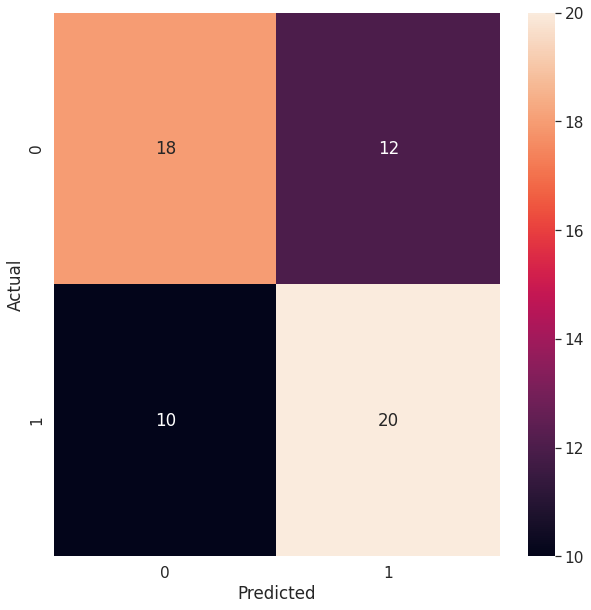

In [ ]:
#nli bert
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.4)
plt.subplots(figsize=(10,10))

sns.heatmap(confusion_matrix_1, annot=True)

plt.show()

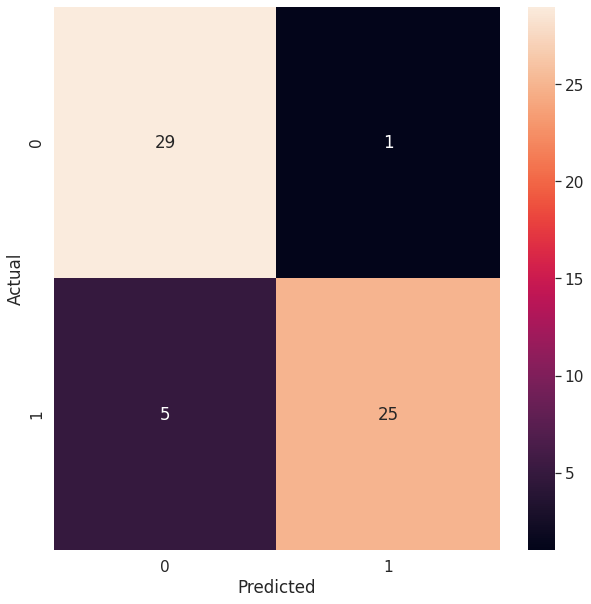

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix_2, annot=True)
#nli BERT-AUGM'

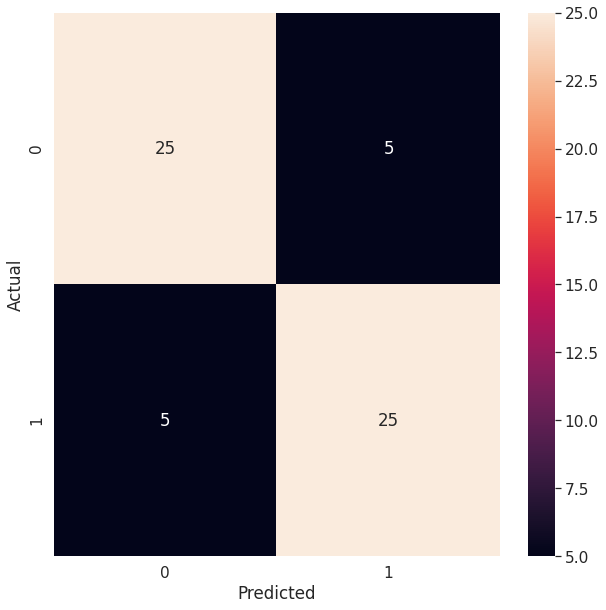

In [ ]:

plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix_3, annot=True)
#nli 'NLI-BERT AUG'


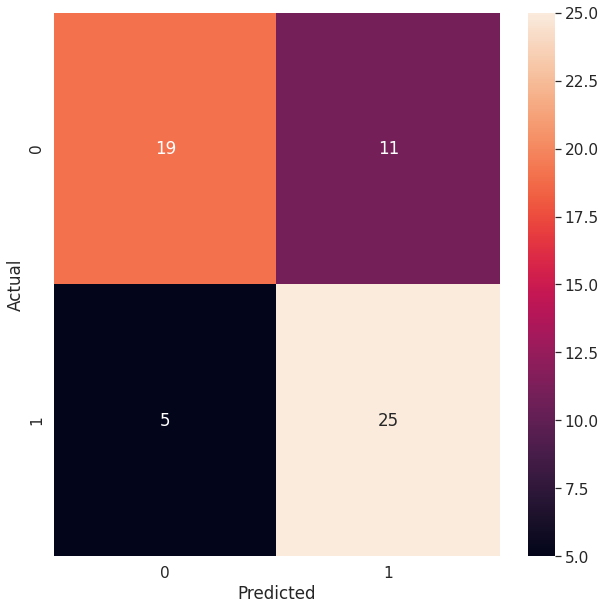

In [ ]:
# 'BERT'
plt.subplots(figsize=(10,10))

sns.heatmap(confusion_matrix_4, annot=True)

In [ ]:
y_train = df['GT'].tolist()
y_test = df['BERT-AUGM'].tolist()
print(f1_score(y_test, y_train, average="macro"))
print(precision_score(y_test, y_train, average="macro"))
print(recall_score(y_test, y_train, average="macro"))  

0.8995535714285714
0.9
0.9072398190045249


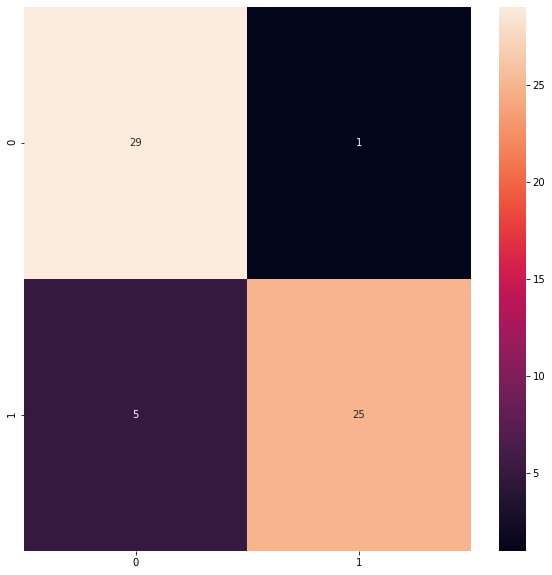

In [ ]:
#BERT AUGMENTED
tagged = df['BERT-AUGM'].to_list()
ref = df['GT'].to_list()
cf_matrix = confusion_matrix(ref, tagged)
plt.subplots(figsize=(10,10))
sns.heatmap(cf_matrix, annot=True)

0.8333333333333334
0.8333333333333334
0.8333333333333334


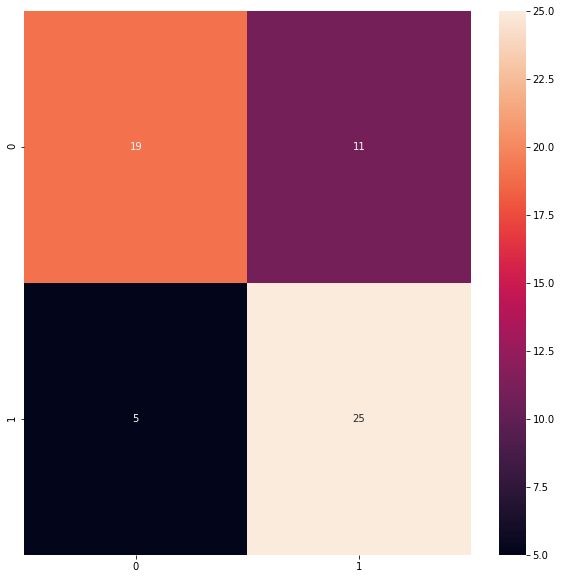

In [ ]:
#BERT
tagged = df['BERT'].to_list()
ref = df['GT'].to_list()
cf_matrix = confusion_matrix(ref, tagged)
plt.subplots(figsize=(10,10))
sns.heatmap(cf_matrix, annot=True)

In [ ]:
y_train = df['GT'].tolist()
y_test = df['BERT'].tolist()
print(f1_score(y_test, y_train, average="macro"))
print(precision_score(y_test, y_train, average="macro"))
print(recall_score(y_test, y_train, average="macro"))  

0.7306397306397308
0.7333333333333334
0.7430555555555556


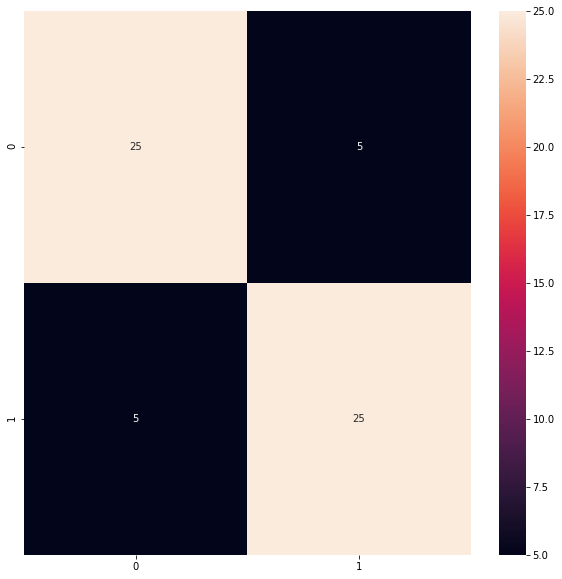

In [ ]:
#BERT AUGMENTED
tagged = df['NLI-BERT AUG'].to_list()
ref = df['GT'].to_list()
cf_matrix = confusion_matrix(ref, tagged)
plt.subplots(figsize=(10,10))
sns.heatmap(cf_matrix, annot=True)

In [ ]:
y_train = df['GT'].tolist()
y_test = df['NLI-BERT AUG'].tolist()
print(f1_score(y_test, y_train, average="macro"))
print(precision_score(y_test, y_train, average="macro"))
print(recall_score(y_test, y_train, average="macro"))  